1. 동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근의 기술을 다룬다.
2. 간단한 스티커부터 시작해 각도 변화가 가능하고 거리 변화에 강건한 스티커까지 만들어본다.
- 얼굴인식 카메라의 흐름 이해
- dlib 라이브러리 사용
- 이미지 배열의 인덱싱 예외 처리  

스티커를 세밀하고 자연스럽게 적용하기 위해서 눈, 코, 입, 귀와 같은 얼굴 각각의 위치를 아는 것이 중요하다. 이 위치들을 찾아내는 기술을 **랜드마크(landmark)** 또는 **조정(alignment)**라고 한다. 조금 더 큰 범위로는 keypoint detection이라고 부른다.  
대부분의 face landmark 데이터셋은 눈, 코, 입과 턱을 포함하고 있다. 얼굴의 랜드마크를 찾아냈다면 머리의 위치를 예상하는 것은 쉽다. 눈과 코의 위치로부터 위로 떨어져 있는 정도를 데이터로부터 유추할 수 있을 것이다.

1. 얼굴이 포함된 사진을 준비하고
2. 사진으로부터 얼굴 영역(face landmark)을 찾아낸다. (landmark를 찾기 위해서는 얼굴의 bounding box를 먼저 찾아야 한다.)
3. 찾아진 영역으로부터 머리에 왕관 스티커를 붙여넣는다.

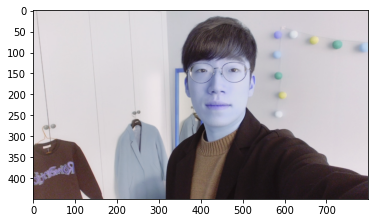

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

my_image_path = '/content/images/image.png'
img_bgr = cv2.imread(my_image_path) # OpenCV로 이미지 로드
img_show = img_bgr.copy()  # 출력용 이미지 따로 보관
plt.imshow(img_bgr)
plt.show()

사진의 색상에 푸른빛이 감도는 것은 opencv의 특징 때문이다. matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB 순으로 사용하는데, opencv는 예외적으로 BGR을 사용한다. 따라서 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력된 것이다.  
opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 아래와 같은 색깔 보정처리를 해줘야 한다.

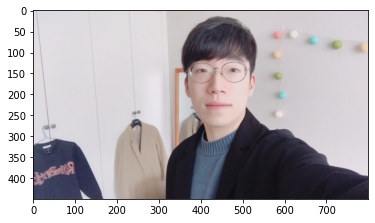

In [2]:
# plt.imshow() 이전에 RGB 이미지로 바꾼다.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### face detection
Object Detection 기술을 이용해 얼굴의 위치를 찾아보자.  
dlib의 `face detector`는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해 얼굴을 찾는다.  
HOG는 이미지에서 색상의 변화량을 나타낸 것이다. 딥러닝이 나오기 전에 다양하게 사용되던 방식으로, 이미지에서 단순히 색상값만 갖고 할 수 있는 일이 제한적이었기 때문에 색상의 변화량을 계산한 HOG는 굉장히 큰 도움이 되었다.  
SVM은 선형 분류기다. 한 이미지를 다차원 공간의 한 벡터라고 보면 여러 이미지는 여러 벡터가 되는데, 이 여러 벡터를 구분짓는 방법이다. 
이미지의 색상만 가지고는 SVM이 큰 힘을 발휘하지 못하는데 이미지가 HOG를 통해 벡터로 만들어진다면 SVM이 잘 작동한다.  

그렇다면 얼굴의 위치는 어떻게 찾을 수 있을까? sliding window를 사용한다.  
sliding window는 작은 영역(window)을 이동해가며 확인하는 방법을 말한다. 큰 이미지의 작은 영역을 잘라 얼굴이 있는지 확인하고, 다시 작은 영역을 옆으로 옮겨 얼굴이 있는지 확인하는 방식이다. 이 방식은 이미지가 크면 클수록 오래 걸리는 단점이 있는데, 바로 이 지점이 딥러닝이 필요한 이유이기도 하다.

dlib을 활용해 hog detector를 선언한다.

In [3]:
# detector를 선언한다.
detector_hog = dlib.get_frontal_face_detector()

# detector_hog를 이용해 얼굴의 bounding box를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # (image, num of image pyramid)

dlib은 rgb 이미지를 입력으로 받기 때문에 `cvtColor()`를 이용해서 opencv의 bgr 이미지를 rgb로 변환한다.  
`detector_hog`의 두번째 파라미터는 이미지 피라미드의 수이다. 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 한다. 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능하다. 

>upsampling이란, 간단하게 데이터의 크기를 키우는 것을 말한다. 일반적으로 CNN의 레이어를 통과하면서 이미지의 크기를 줄이는 것을 down sampling이라고 하는데, down sampling의 반대 개념이 upsampling이다.

rectangles[[(345, 98) (531, 284)]]


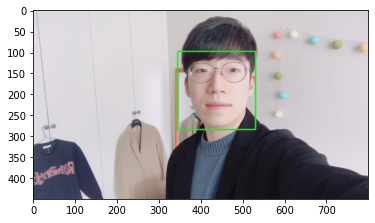

In [4]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있다.
print(dlib_rects)

for dlib_rect in dlib_rects:
  l = dlib_rect.left()
  t = dlib_rect.top()
  r = dlib_rect.right()
  b = dlib_rect.bottom()

  cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

dlib detector는 `dlib.rectangles` 타입의 객체를 반환한다. `dlib.rectangles`는 `dlib.rectangle` 객체의 배열 형태로 이루어져 있다.  
`dlib.rectangle` 객체는 `left(), top(), right(), bottom(), height(), width()` 등의 멤버 함수를 포함하고 있다. 

### face landmark
스티커를 섬세하게 적용하기 우해서는 이목구비의 위치를 아는 것이 중요하다. 이목구비의 위치를 추론하는 것은 face landmark localization 기술이라고 한다.  
face landmark는 detection의 결과물인 bounding box로 잘라낸(crop) 얼굴 이미지를 이용한다.

#### object keypoint estimation 알고리즘
face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 한다. keypoint를 찾는 알고리즘은 크게 2가지로 이루어진다.  
1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측
2. bottom-up : 이미지 전체의 keypoing를 먼저 찾고 point 관계를 이용해 군집화해서 box 생성

In [5]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

--2022-01-11 10:09:25--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  79.3MB/s    in 0.8s    

2022-01-11 10:09:26 (79.3 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [6]:
mv shape_predictor_68_face_landmarks.dat.bz2 /content/models/

In [7]:
!bzip2 -d /content/models/shape_predictor_68_face_landmarks.dat.bz2

bzip2: Output file /content/models/shape_predictor_68_face_landmarks.dat already exists.


In [8]:
# 저장된 landmark 모델 불러오기
model_path = '/content/models/shape_predictor_68_face_landmarks.dat'
landmakr_predictor = dlib.shape_predictor(model_path)

`landmark_predictor`는 `RGB 이미지`와 `dlib.rectangle`을 입력받아 `dlib.full_object_detection`을 반환한다. 

In [9]:
list_landmarks = []

# 얼굴 영역 박스마다 face landmark를 찾아낸다.
for dlib_rect in dlib_rects:
  points = landmakr_predictor(img_rgb, dlib_rect)
  # face landmark 좌표를 지정한다.
  list_points = list(map(lambda p: (p.x, p.y), points.parts()))
  list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


`points`는 `dlib.full_object_detection`의 객체이기 때문에 `parts()` 함수로 개별 위치에 접근할 수 있다. 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환해 주었다. 따라서 `list_points`는 tuple (x, y) 68개로 이루어진 리스트가 된다. 이미지에서 찾아진 얼굴 개수마다 반복하면 `list_landmark`에 68개의 랜드마크가 얼굴 개수만큼 지정된다.

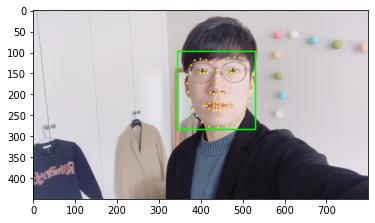

In [10]:
for landmark in list_landmarks:
  for point in landmark:
    cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 스티커 적용하기
랜드마크를 기준으로 눈썹 위 얼굴 중앙에 스티커를 씌우면 된다. 구현 방법은 여러 가지가 있다. 코 중심을 기준으로 높이 x 이상에 그려도 되고, 눈썹 위 n 픽셀 위에 스티커를 구현해도 된다.  
중요한 것은 얼굴 위치, 카레가의 거리에 따라 픽셀 x가 다르기 때문에 비율로 계산을 해줘야 한다.

In [11]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
  print(landmark[30]) # 코의 index는 30
  x = landmark[30][0]
  y = landmark[30][1] - dlib_rect.height()//2
  w = h = dlib_rect.width()
  print('(x,y) : (%d, %d)'%(x,y))
  print('(w,h) : (%d, %d)'%(w,h))

(437, 182)
(x,y) : (437, 89)
(w,h) : (187, 187)


In [12]:
sticker_path = '/content/images/king.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지 로드
img_sticker = cv2.resize(img_sticker, (w, h))
print(img_sticker.shape)

(187, 187, 3)


원본 이미지에 스티커 이미지를 추가하기 위해 x, y 좌표를 조정한다. 이미지 시작점은 top-left 좌표이기 때문이다.

In [13]:
refined_x = x - w // 2
refined_y = y - h
print('(x,y) : (%d, %d)'%(refined_x, refined_y))

(x,y) : (344, -98)


스티커의 시작점이 얼굴 사진의 영역을 벗어나면 음수로 표현된다. 그런데 opencv 데이터는 numpy ndarray 형태의 데이터를 사용한다. ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외처리를 해줘야 한다. 따라서 원본 이미지의 범위를 벗어난 스티커 부분을 제거해줘야 한다.  
사실 스티커가 원본 이미지의 범위를 넘어가는 경우는 하나 더 있다. 바로 스티커의 시작점 + 스티커 사진의 크기가 원본 이미지의 크기보다 큰 경우다.

In [14]:
if refined_x < 0:
  img_sticker = img_sticker[:, -refined_x:]
  refined_x = 0
if refined_y < 0:
  img_sticker = img_sticker[-refined_y:, :]
  refined_y = 0

print('(x,y) : (%d, %d)'%(refined_x, refined_y))

(x,y) : (344, 0)


-y 크기만큼 스티커를 crop하고, top의 x좌표와 y좌표를 각각의 경우에 맞춰 원본 이미지의 경계값으로 수정하면 위와 같은 형식으로 나온다.  
이제 원본 이미지에 스티커를 적용해보자.

In [15]:
# 길어서 복잡해보이지만 img_show[from:to] 형식이다.
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

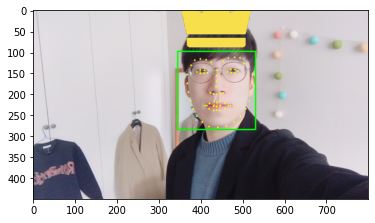

In [16]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

이제 bounding box와 landmark를 제거하고 최종 결과만 출력해보자. `img_show` 대신 `img_rgb`를 활용한다.

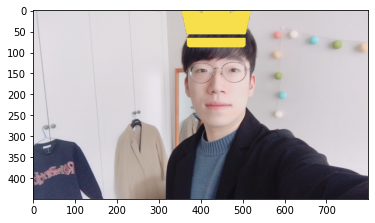

In [17]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()